# Extra code / analyses not as useful

In [16]:
import json
import numpy as np
import tweetExplore_fns as fns
import tweetExplore_extrafns as fns2
import importlib
import matplotlib
import matplotlib.pyplot as plt
from textblob import TextBlob
from matplotlib import gridspec
import seaborn as sns
import pandas as pd

sns.set_context("talk")
sns.set_style('darkgrid')

importlib.reload(fns);
importlib.reload(fns2);
%matplotlib inline


In [4]:
#  import data 
with open('../data/raw_tweets1_5hr_candidates.json') as data_file:
    rawdata = json.load(data_file)

# selects only tweets that have text 
tweet_list = fns.extract_tweets(rawdata)
        
#  extract indices for tweets that also have a fields of interest
coord_index_list = fns.extract_indices(tweet_list,"coordinates")

# extract tweets that also have a gps coordinate 
coord_tweet_list = fns.extract_tweets_fieldOfInterest(tweet_list,"coordinates")

print('N Tweets', len(tweet_list),'N coordinates:',len(coord_index_list))

N Tweets 189042 N coordinates: 129


In [5]:
candidates = ['Trump','Cruz','Kasich','Rubio','Carson','Clinton','Sanders'] #track list

# for each candidate
tweet_index_store = []
subjectivity_store = []
polarity_store = []
for iperson,val in enumerate(candidates):
    # save each candidate's list of polarity etc. in a list 
    person_sentiment_polarity, person_sentiment_subjectivity, person_tweetInd = \
    fns.extract_sentiment(tweet_list,candidates[iperson])
    # store tweet polarity (sentiment pos/neg) for each candidate
    polarity_store.append(person_sentiment_polarity)
    # store tweet subjectivity for each candidate
    subjectivity_store.append(person_sentiment_subjectivity)
    # store indices for tweets about each candidate
    tweet_index_store.append(person_tweetInd)

Trump   # tweets: 110392
Cruz   # tweets: 18673
Kasich   # tweets: 1601
Rubio   # tweets: 42703
Carson   # tweets: 2608
Clinton   # tweets: 9846
Sanders   # tweets: 7256


In [6]:
candidate_tweets = []

# for each candidate, get counts of: 
# tweets, positive tweets, negative tweets,
# average positive sentiment, average negative sentiment
for iperson,candidate in enumerate(candidates):
    candidate_tweets.append(len(tweet_index_store[iperson])) # number tweets total
    

### Plots correlation of GOP only 538 polls and % tweets per candidate, and provides p-value

GOP only correlation coefficient between 538 Avg Polls and Number of Tweets: 0.949


//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


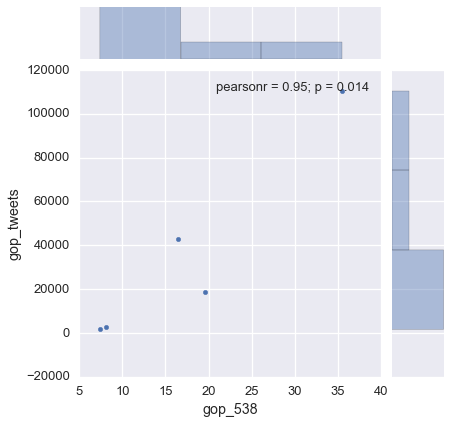

In [7]:
# 538 Polling averages from 2/26/16 
# ['Trump','Cruz','Kasich','Rubio','Carson','Clinton','Sanders'] (reminder of order)
avg_538 = [35.5, 19.6, 7.4, 16.4, 8.1, 50.3, 38.6]


rep_numTweets_538_pearson_corr = np.corrcoef(avg_538[:5],candidate_tweets[:5])
d = {'gop_538' : pd.Series(avg_538[:5], index=candidates[:5]), 'gop_tweets' : pd.Series(candidate_tweets[:5], index=candidates[:5])}

print('GOP only correlation coefficient between 538 Avg Polls and Number of Tweets: %0.3f' % rep_numTweets_538_pearson_corr[0][1])

data_gop = pd.DataFrame(d)
# data_gop = np.array([gop_538, gop_tweets])
g = sns.jointplot(x = 'gop_538', y= 'gop_tweets', data = data_gop)

# Not clean / figured out


- Does the main issue change across candidates though? (Does Trump fight over different things with each candidate?)

In [17]:
rival_index_store = []
rival_count_store = []

# for each candidate
for iperson,val in enumerate(candidates):
    current_inds = tweet_index_store[iperson]
    count = [0]*len(candidates)
    # remove current candidate from list, so cannot be own rival
    rival_list_temp = np.arange(len(candidates)) 
    mask_self = np.ones(rival_list_temp.shape,dtype=bool)
    mask_self[iperson] = 0
    rival_list = rival_list_temp[mask_self]
    rival_index_temp = []
    [rival_index_temp, count] = fns.rival_count(rival_list,current_inds, candidates, tweet_list)
    rival_count_store.append(count)
    rival_index_store.append(rival_index_temp)
    print(val,count)
    
maxRival = []
maxRival_ind = []
storeRivalTweets = []

for icand, cand in enumerate(candidates):
    # get list of all candidates except current one
    rival_list_temp = np.arange(len(candidates)) 
    mask_self = np.ones(rival_list_temp.shape,dtype=bool)
    mask_self[icand] = 0
    rival_array = rival_list_temp[mask_self]
    rival_list = rival_array.tolist()
    
    # get max count index of simultaneous mentions to select top rival 
    cur_maxRival_ind = np.argmax(rival_count_store[icand])
    # store index of max rival 
    maxRival_ind.append(cur_maxRival_ind)
    # store rival name 
    maxRival.append(candidates[cur_maxRival_ind])

    # index of rival from rival only list
    rival_only_ind = rival_list.index(cur_maxRival_ind)
    # store tweets with rival 
    storeRivalTweets.append(rival_index_store[icand][rival_only_ind])
    print(cand,"'s top rival is:",candidates[cur_maxRival_ind])

Trump [0, 6336, 647, 17940, 515, 1426, 672]
Cruz [6336, 0, 585, 6346, 456, 229, 130]
Kasich [647, 585, 0, 651, 411, 17, 11]
Rubio [17940, 6346, 651, 0, 451, 283, 150]
Carson [515, 456, 411, 451, 0, 6, 14]
Clinton [1426, 229, 17, 283, 6, 0, 1367]
Sanders [672, 130, 11, 150, 14, 1367, 0]
Trump 's top rival is: Rubio
Cruz 's top rival is: Rubio
Kasich 's top rival is: Rubio
Rubio 's top rival is: Trump
Carson 's top rival is: Trump
Clinton 's top rival is: Trump
Sanders 's top rival is: Clinton


In [18]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import re
candidates = ['Trump','Bush','Cruz','Kasich','Rubio','Clinton','Sanders'] #track list

for icand, val in enumerate(candidates):
    print(icand, val,maxRival[icand])
    current_inds = storeRivalTweets[icand]
    textstring = []
    newSTOP = STOPWORDS
    newSTOP.union({'co','https','\'s','RT','\"RT','https','https:','\'https','Trump','#Trump','Trump\'s', maxRival[icand],'#'+ maxRival[icand],maxRival[icand]+'\'s'})
    stoplistk = ['co','https','\'s','RT','\"RT','https','https:','\'https','Trump','#Trump','Trump\'s', maxRival[icand],'#'+ maxRival[icand],maxRival[icand]+'\'s']
    for iInd, val in enumerate(current_inds):
        curtweet = tweet_list[current_inds[iInd]]
        curtext = curtweet["text"]
        textstring.append(curtext)
    
    textjoined = ''
    for tweet in textstring:
#         print(tweet)
        textjoined = textjoined + ' ' + tweet
    textsplit = textjoined.split()
    newlist = [w for w in textsplit if not w in newSTOP]
    newlist = [w for w in newlist if not w in stoplistk]
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    newlist = [pattern.sub('', w) for w in newlist] 
    pattern2 = re.compile('.Trump.')
    newlist = [pattern2.sub('',w) for w in newlist]
    # print(klist)
    
    newstring = " ".join(newlist)
    textstringblob = TextBlob(newstring)
#     print(textstringblob.words)

    
    for iword in newSTOP:
#         print(iword)
        textstringblob.replace(iword,'')
#     print(textstringblob,'new')
    words = textstringblob.words
    word_counts = Counter(words)
    top_three = word_counts.most_common(10)
    print(top_three)
   

0 Trump Rubio
[('amp', 5737), ('Christie', 4729), ('I', 3693), ('Donald', 3269), ('Marco', 3245), ('Chris', 3238), ('Cruz', 3210), ('Trump', 3145), ('now', 2881), ('right', 2614)]
1 Bush Rubio
[('Cruz', 5943), ('last', 1061), ('amp', 1000), ('Ted', 999), ('Marco', 958), ('…', 940), ('Rubio', 882), ('Trump', 711), ('I', 707), ('night', 678)]
2 Cruz Rubio
[('Kasich', 478), ('Cruz', 393), ('Carson', 286), ('…', 152), ('8', 144), ('25', 144), ('GOP', 135), ('KASICH', 134), ('RUBIO', 132), ('CRUZ', 125)]
3 Kasich Trump
[('Rubio', 20694), ('amp', 5737), ('Christie', 4729), ('I', 3693), ('Donald', 3269), ('Marco', 3245), ('Chris', 3238), ('Cruz', 3210), ('Trump', 3145), ('now', 2881)]
4 Rubio Trump
[('Carson', 493), ('Rubio', 389), ('Cruz', 337), ('Kasich', 275), ('8', 135), ('GOP', 131), ('5', 105), ('Trump', 91), ('16', 90), ('Ben', 86)]
5 Clinton Trump
[('Clinton', 1416), ('Hillary', 469), ('Trump', 351), ('Christie', 326), ('Donald', 311), ('vs', 285), ('…', 269), ('I', 212), ('will', 188

In [19]:
# from nltk.corpus import stopwords
# templist = stopwords.words('english')
# templist
# newset = ('co','Trump')
# print(type(newset))
# newSTOP = tempstop.update(newset)
# print(newSTOP)
# # type(newSTOP)
#     newSTOP.update('co','https','\'s','RT','\"RT','\'https','Trump')
stoplist = ['co','https*','\'s','RT','\"RT','\'https','Trump','Rubio']
klist = [w for w in newlist if not w in stoplist]
import re
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
klist = [pattern.sub('', w) for w in klist] 
print(klist)

['Students', 'lined', 'see', 'Sen.', 'Bernie', 'Sanders', 'Claflin', 'U.', 'Hillary', 'will', 'rally', 'nearby', 'SC', 'State', 'U.', '', '@LivingOnChi:', 'H.', 'A.', 'Goodman:', 'Why', "I'm", 'Voting', 'Bernie', 'Sanders', 'Over', '-', '...', '', 'via', '@YouTube', '#StandTog…', '@NateSilver538:', 'Meanwhile,', 'state', 'polls', 'started', 'look', 'really', 'good', 'her.', 'Sanders', 'lot', 'catching', 'do.', 'https…', 'White', 'Privilege', 'Helps', 'Hillary', 'Survive', 'Controversy.', 'Bernie', 'Sanders', 'Was', 'Arrested', '1963', '', 'via', '@HuffPostPol', '@incoduce', 'I', 'think', 'Sanders', 'reparations', 'plan,', 'seems', 'to:', '', 'There', 'needs', 'one.', 'New', 'trending', 'story', 'TIME:', 'Hillary', 'Has', 'Big', 'Lead', 'Over', 'Bernie', 'Sanders', 'Florida', 'Poll', '@business:', "Here's", 'Wal-Mart', 'explains', 'difference', 'Sanders', '', '', '@TIME:', 'Hillary', 'big', 'lead', 'Bernie', 'Sanders', 'Florida', 'poll', '', 'Hillary', 'Has', 'Big', 'Lead', 'Over', 'Ber

In [22]:
# sort tweets into positive/negative lists for each candidate 

store_pos_polarity = []
store_ind_pos_polarity = []
store_tweet_pos_polarity = []
store_neg_polarity = []
store_ind_neg_polarity = []
store_tweet_neg_polarity = []
pos_neg_ratio = []
pos_tweets = []
neg_tweets = []
avg_pos = []
avg_neg = []

# for each candidate
for iperson,val in enumerate(candidates):
    # sort each sentiment score into positive or negative sentiment categories, outputs are:
    # lists of each pos. and neg. sentiment score: pos_polarity, neg_polarity
    # lists of the indices for each tweet w. a pos/neg score: ind_pos_polarity, ind_neg_polarity
    # lists of the texts for each tweet that has a pos/neg tscore: 
                                        #tweet_pos_polarity, tweet_neg_polarity
    pos_polarity, neg_polarity, ind_pos_polarity, ind_neg_polarity, \
    tweet_pos_polarity, tweet_neg_polarity = \
    fns.sortTweetsPosNeg(iperson, polarity_store, tweet_index_store, tweet_list)
    
    # store each candidates lists in a master list
    store_pos_polarity.append(pos_polarity)             # positive sentiment scores
    store_ind_pos_polarity.append(ind_pos_polarity)     # indices of tweets w. pos. scores
    store_tweet_pos_polarity.append(tweet_pos_polarity) # positive tweet texts
    store_neg_polarity.append(neg_polarity)             # negative sentiment scores
    store_ind_neg_polarity.append(ind_neg_polarity)     # indices of tweets w. neg. scores 
    store_tweet_neg_polarity.append(tweet_neg_polarity) # negative tweet texts
    
    # get the ratio of positive to negative tweets
    pos_neg_ratio.append(len(ind_pos_polarity)/len(ind_neg_polarity))
    
    # get counts of # of pos/neg tweets, and the average pos/neg sentiment scores
    pos_tweets.append(len(ind_pos_polarity)) # number positive tweets
    neg_tweets.append(len(ind_neg_polarity)) # number negative tweets
    avg_pos.append(np.average(pos_polarity)) # avg positive tweet sentiment score
    avg_neg.append(np.average(neg_polarity)) # avg negative tweet sentiment score
    
    # print number of positive/negative tweets per person, 
    # and their average positive/negative sentiment score
    print(candidates[iperson],'# Tweets: Positive',len(ind_pos_polarity),
          'Negative',len(ind_neg_polarity), ' Avg. Sentiment: Positive %.2f' \
          % np.average(pos_polarity),'Negative %.2f' % np.average(neg_polarity))

Trump # Tweets: Positive 37515 Negative 21795  Avg. Sentiment: Positive 0.35 Negative -0.30
Bush # Tweets: Positive 7248 Negative 3368  Avg. Sentiment: Positive 0.34 Negative -0.29
Cruz # Tweets: Positive 638 Negative 296  Avg. Sentiment: Positive 0.37 Negative -0.23
Kasich # Tweets: Positive 14692 Negative 11474  Avg. Sentiment: Positive 0.32 Negative -0.25
Rubio # Tweets: Positive 885 Negative 413  Avg. Sentiment: Positive 0.39 Negative -0.25
Clinton # Tweets: Positive 3577 Negative 1792  Avg. Sentiment: Positive 0.35 Negative -0.24
Sanders # Tweets: Positive 2184 Negative 1333  Avg. Sentiment: Positive 0.32 Negative -0.26


//anaconda/lib/python3.5/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


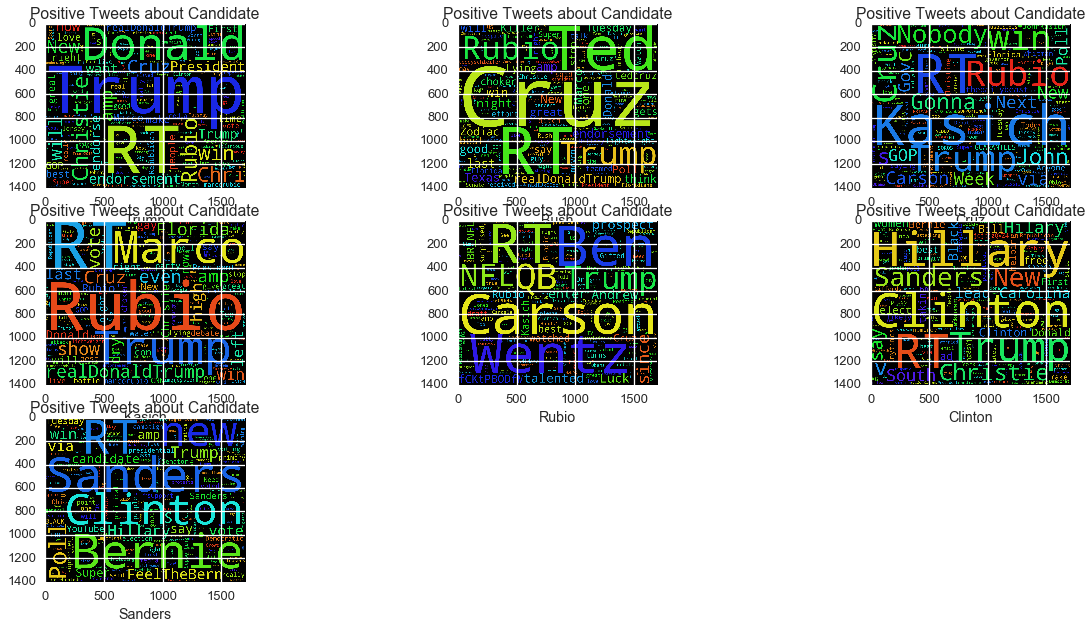

In [23]:
ind = np.arange(len(candidates))  # the x locations for the groups
width = 0.35       # the width of the bars
from matplotlib import gridspec
fig = plt.figure(figsize = (40,10)) #figsize=(90, 90)
ax = []
gs = gridspec.GridSpec(3, 3, width_ratios=[1]*len(candidates))
for i, val in enumerate(candidates):
    ax.append(plt.subplot(gs[i]))
    tempwordcloud = fns2.makeWordcloud(store_tweet_pos_polarity[i])
    ax[i].imshow(tempwordcloud)
    # add some text for labels, title and axes ticks
    ax[i].set_title('Positive Tweets about Candidate')
    ax[i].set_xlabel(candidates[i])

plt.show()

## Plot geographical coordinates of tweets

In [24]:
# This just lets the output of the following code samples
#  display inline on this page, at an appropriate size.
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (10,20)

NameError: name 'coords' is not defined

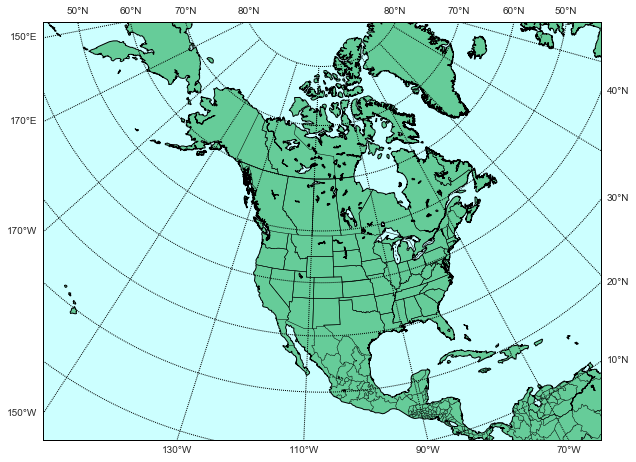

In [26]:
import matplotlib
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
# setup Lambert Conformal basemap.
m = Basemap(projection='lcc',width=12000000,height=9000000,
            resolution='l',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
#draw boundary, fill ocean color
m.drawmapboundary(fill_color='#CCFFFF')
# fill continents, set lake color
m.fillcontinents(color='#66CC99',lake_color='#CCFFFF') # '#6699CC'
# draw parallels and meridians. label only on edges of map
parallels = np.arange(0.,81,10.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])
# drawstates, if no linewidth will be empty
m.drawstates(linewidth = .5)
m.drawcoastlines()
m.drawcountries()
# m.drawcounties(linewidth = 0.05, linestyle = 'solid', color = 'k', antialiased = 1)

i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = m(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = m(xpt,ypt,inverse=True)
    m.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()

In [ ]:
rcParams['figure.figsize'] = (20,20)

 
# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1
# my_map = Basemap(projection='ortho', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
# my_map = Basemap(projection='robin', lat_0=50, lon_0=-100,
#               resolution='l', area_thresh=1000.0)
my_map = Basemap(projection='merc', lat_0=42.36, lon_0=-71.06,
              resolution='h', area_thresh=.01, 
              llcrnrlon=-71.3, llcrnrlat=42.1,
              urcrnrlon=-70.9, urcrnrlat=42.6) 
#               llcrnrlon=-71.098709, llcrnrlat=42.328093,
#               urcrnrlon=-71.012192, urcrnrlat=42.389994) 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='#66CC99')
my_map.drawstates(linewidth = .5)
my_map.drawmapboundary()
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))
# my_map.drawcounties(linewidth = 0.5)

# lon = -135.3318
# lat = 57.0799
# x,y = my_map(lon, lat)
# my_map.plot(x, y, 'bo', markersize=12)
i = 0
while i < len(coords):
    # get current coordinates 
    lon, lat = coords[i]
    # convert to map projection coords.
    # Note that lon,lat can be scalars, lists or numpy arrays.
    xpt,ypt = my_map(lon,lat)
    # convert back to lat/lon
    lonpt, latpt = my_map(xpt,ypt,inverse=True)
    my_map.plot(xpt,ypt,'ro')  # plot a blue dot there
    label = 'Hello'
    plt.Text(xpt+1000, ypt+5000, label)
    # put some text next to the dot, offset a little bit
    # (the offset is in map projection coordinates)
#     plt.text(xpt+100000,ypt+100000,'Boulder (%5.1fW,%3.1fN)' % (lonpt,latpt))
#     plt.text(xpt+100000,ypt+100000,'(%5.1fW,%3.1fN)' % (i,lonpt,latpt))
    i = i + 1
plt.show()